# Installing Dependencies

In [1]:
!pip install tensorflow tensorflow-gpu matplotlib opencv-python

In [2]:
import cv2
import uuid
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

# Set GPU growth

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus :
    tf.config.experimental.set_memory_growth(gpu,True)

In [5]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Path to Anchor, Positives and Negatives 

In [4]:
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative')
ANC_PATH = os.path.join('data','anchor')

In [7]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

# LFW Dataset

In [ ]:
!tar -xf lfw.tgz

In [16]:
for directory in os.listdir('lfw') :
    for file in os.listdir(os.path.join('lfw',directory)):
        EX_PATH = os.path.join('lfw',directory,file)
        NEW_PATH = os.path.join(NEG_PATH,file)
        os.replace(EX_PATH,NEW_PATH)

# Collect Positive and Anchor classes

In [9]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    frame = frame[120:120+250,200:200+250,:]
    
    cv2.imshow('Image Collection',frame)
    
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)
        
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)
        
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

# Process the dataset

In [5]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [6]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img,(100,100))
    img = img/255.0
    return img

In [111]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

In [16]:
positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [10]:
tf.data.Dataset.zip??

In [13]:
samples = data.as_numpy_iterator()

In [15]:
example = samples.next()

In [16]:
example

(b'data\\anchor\\b289618b-77d8-11ec-99cf-95ffa8330d45.jpg',
 b'data\\positive\\e96790b2-77d8-11ec-bc80-95ffa8330d45.jpg',
 1.0)

In [12]:
data

<ConcatenateDataset shapes: ((), (), ()), types: (tf.string, tf.string, tf.float32)>

In [1]:
def preprocess_twin(input_img,validation_img,label) :
    return(preprocess(input_img),preprocess(validation_img), label)

tf.Tensor(
[[[0.825      0.81715685 0.76617646]
  [0.81985295 0.8120098  0.764951  ]
  [0.8254902  0.81764704 0.7705882 ]
  ...
  [0.17279412 0.1502451  0.08455882]
  [0.16740195 0.14705883 0.07401961]
  [0.17377451 0.14632353 0.0747549 ]]

 [[0.8247549  0.81691176 0.76593137]
  [0.8208333  0.8129902  0.76593137]
  [0.8372549  0.82941175 0.7823529 ]
  ...
  [0.15563725 0.14093137 0.10759804]
  [0.15465686 0.13995098 0.10661764]
  [0.16323529 0.13799019 0.10637255]]

 [[0.83210784 0.8242647  0.7762255 ]
  [0.81936276 0.8115196  0.7644608 ]
  [0.84044117 0.83259803 0.7855392 ]
  ...
  [0.14754902 0.13799019 0.11176471]
  [0.15563725 0.14607844 0.11838235]
  [0.1742647  0.15465686 0.13112745]]

 ...

 [[0.11936274 0.16446078 0.15759803]
  [0.11985294 0.16323529 0.15710784]
  [0.11764706 0.14117648 0.1264706 ]
  ...
  [0.2720588  0.33088234 0.31911764]
  [0.31053922 0.36053923 0.35171568]
  [0.32818627 0.3752451  0.36740196]]

 [[0.10784314 0.14632353 0.14240196]
  [0.10465686 0.14803922 0

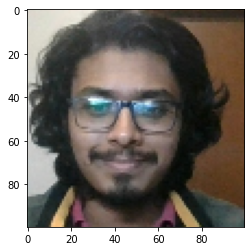

In [116]:
res = preprocess_twin(*example)
print(res[0])
plt.imshow(res[1])

In [15]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

NameError: name 'data' is not defined

In [33]:
round(len(data)*.7)

420

In [17]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [18]:
train_data

<PrefetchDataset shapes: ((None,), (None,), (None,)), types: (tf.string, tf.string, tf.float32)>

In [19]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [20]:
test_data.batch??

# Model 

In [42]:
def make_embedding():
    inp = Input(shape=(100,100,3),name='input_image')
    
    
    c1 = Conv2D(64,(10,10),activation='relu')(inp)
    m1 = MaxPooling2D(64,(2,2),padding='same')(c1)
    
    
    c2 = Conv2D(128,(7,7),activation='relu')(m1)
    m2 = MaxPooling2D(64,(2,2),padding='same')(c2)
    
    c3 = Conv2D(128,(4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64,(2,2), padding='same')(c3)
    
    c4 = Conv2D(256,(4,4),activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp],outputs=[d1],name='embedding')

In [47]:
embedding = make_embedding()

In [48]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 17, 17, 128)       26

In [7]:
class L1Dist(Layer) :
    def __init__(self, **kwargs):
        super().__init__()
        
    def call(self,input_embedding,validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [8]:
l1 = L1Dist()

In [24]:
l1(anchor_embedding,validation_embedding)

NameError: name 'anchor_embedding' is not defined

In [21]:
def make_siamese_model():
    
    input_image = Input(name='input_img',shape=(100,100,3))
    
    
    validation_image = Input(name='validation_img',shape=(100,100,3))
    
    
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image),embedding(validation_image))
    
    classifier = Dense(1,activation='sigmoid')(distances)
    
    return Model(inputs=[input_image,validation_image],outputs=classifier,name='SiameseNetwork')

In [22]:
siamese_network = make_siamese_model()

NameError: name 'embedding' is not defined

In [55]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Training

In [62]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [63]:
opt = tf.keras.optimizers.Adam(1e-4) #0.0001

In [64]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt,siamese_model=siamese_network)

In [65]:
@tf.function
def train_step(batch):
    
    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]
        
        yhat = siamese_network(X,training=True)
        loss = binary_cross_loss(y,yhat)
    print(loss)
    
    grad = tape.gradient(loss,siamese_network.trainable_variables)
    
    opt.apply_gradients(zip(grad,siamese_network.trainable_variables))
    
    return loss

In [66]:
def train(data,EPOCHS):
    
    for epoch in range(1,EPOCHS+1) :
        print('\n EPOCH {}/{}'.format(epoch,EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        for idx, batch in enumerate(train_data) :
            train_step(batch)
            progbar.update(idx+1)
            
        if epoch % 10 ==0 :
            checkpoint.save(file_prefix = checkpoint_prefix)

In [67]:
EPOCHS = 50

In [68]:
train(train_data,EPOCHS)


 EPOCH 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 25s 444ms/step

 EPOCH 2/50
27/27 [==============================] - 11s 435ms/step

 EPOCH 3/50
27/27 [==============================] - 11s 435ms/step

 EPOCH 4/50
27/27 [==============================] - 12s 438ms/step

 EPOCH 5/50
27/27 [==============================] - 12s 441ms/step

 EPOCH 6/50
27/27 [==============================] - 12s 443ms/step

 EPOCH 7/50
27/27 [==============================] - 12s 444ms/step

 EPOCH 8/50
27/27 [==============================] - 12s 444ms/step

 EPOCH 9/50
27/27 [==============================] - 12s 445ms/step

 EPOCH 10/50
27/27 [==============================] - 12s 446ms/step

 EPOCH 11/50
27/27 [==============================] - 12s 446ms/step

 EPOCH 12/50
27/27 [==============================] - 12s 447ms/step

 EPOCH 13/50
2

# Evaluation

In [71]:
from tensorflow.keras.metrics import Precision, Recall

In [28]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [29]:
test_var = test_data.as_numpy_iterator().next()

In [30]:
test_var[2]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [31]:
predictions = siamese_network.predict([test_input,test_val])
predictions

NameError: name 'siamese_network' is not defined

In [87]:
[1 if prediction > 0.5 else 0 for prediction in predictions]

[1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1]

In [88]:
y_true

array([1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1.],
      dtype=float32)

In [89]:
m = Recall()
m.update_state(y_true,predictions)
m.result().numpy()

1.0

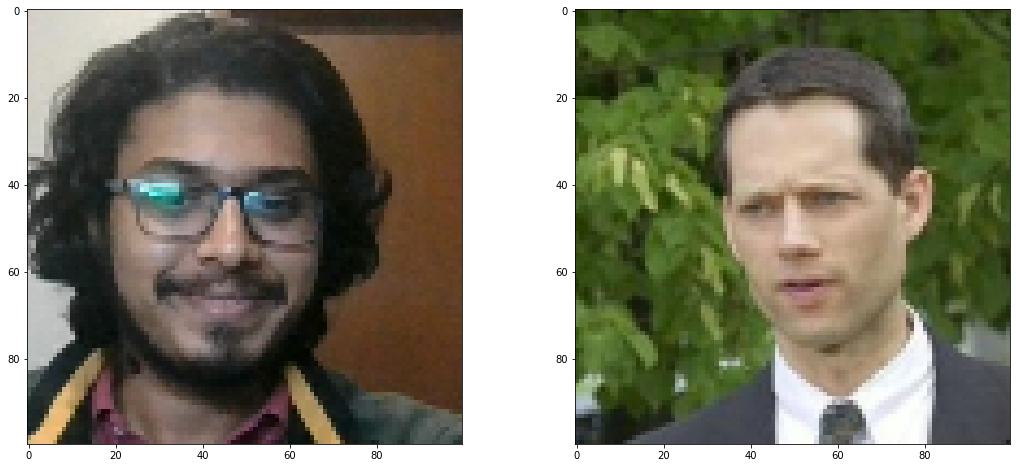

In [96]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.imshow(test_input[9])
plt.subplot(1,2,2)
plt.imshow(test_val[9])
plt.show()

In [97]:
siamese_network.save('SiameseNetwork.h5')

In [9]:
model = tf.keras.models.load_model('SiameseNetwork.h5',
                                  custom_objects = {'L1Dist':L1Dist,'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [32]:
model.predict([test_input,test_val])

ValueError: in user code:

    File "C:\Users\anujp\facial_recognition\face\lib\site-packages\keras\engine\training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\anujp\facial_recognition\face\lib\site-packages\keras\engine\training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\anujp\facial_recognition\face\lib\site-packages\keras\engine\training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\anujp\facial_recognition\face\lib\site-packages\keras\engine\training.py", line 1572, in predict_step
        return self(x, training=False)
    File "C:\Users\anujp\facial_recognition\face\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\anujp\facial_recognition\face\lib\site-packages\keras\engine\input_spec.py", line 227, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "embedding" (type Functional).
    
    Input 0 of layer "conv2d_8" is incompatible with the layer: expected min_ndim=4, found ndim=1. Full shape received: (None,)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None,), dtype=float32)
      • training=False
      • mask=None


In [10]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Real Time

In [10]:
def verify(model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join('application_data','verification_images')):
        input_img = preprocess(os.path.join('application_data','input_image','input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data','verification_images',image))
        
        result = model.predict(list(np.expand_dims([input_img,validation_img],axis=1)))
        results.append(result)
        
    detection = np.sum(np.array(results)> detection_threshold)
    verification = np.sum(np.array(results) > detection_threshold)
    verified = verification > verification_threshold
    
    return results, verified

In [18]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250,:]
    
    cv2.imshow('Verification',frame)
    
    if cv2.waitKey(10) & 0xFF ==ord('v'):
        cv2.imwrite(os.path.join('application_data','input_image','input_image.jpg'),frame)
        results, verified = verify(model, 0.75, 0.2)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

True


In [19]:
np.sum(np.squeeze(results)>0.75)

27

In [20]:
results

[array([[0.83087444]], dtype=float32),
 array([[0.8578721]], dtype=float32),
 array([[0.8468279]], dtype=float32),
 array([[0.88867736]], dtype=float32),
 array([[0.9789621]], dtype=float32),
 array([[0.979634]], dtype=float32),
 array([[0.9680989]], dtype=float32),
 array([[0.9749649]], dtype=float32),
 array([[0.9444143]], dtype=float32),
 array([[0.9293455]], dtype=float32),
 array([[0.7107741]], dtype=float32),
 array([[0.8356244]], dtype=float32),
 array([[0.8397997]], dtype=float32),
 array([[0.3714036]], dtype=float32),
 array([[0.6009078]], dtype=float32),
 array([[0.04555694]], dtype=float32),
 array([[0.01729864]], dtype=float32),
 array([[0.03288048]], dtype=float32),
 array([[0.65892714]], dtype=float32),
 array([[0.54560804]], dtype=float32),
 array([[0.5422498]], dtype=float32),
 array([[0.35904554]], dtype=float32),
 array([[0.04109574]], dtype=float32),
 array([[0.03965401]], dtype=float32),
 array([[0.00908241]], dtype=float32),
 array([[0.00783521]], dtype=float32),
 

In [3]:
!pip install kivy[full] kivy_examples

ERROR: Exception:
Traceback (most recent call last):
  File "c:\users\anujp\facial_recognition\face\lib\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "c:\users\anujp\facial_recognition\face\lib\site-packages\pip\_vendor\urllib3\response.py", line 519, in read
    data = self._fp.read(amt) if not fp_closed else b""
  File "c:\users\anujp\facial_recognition\face\lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 62, in read
    data = self.__fp.read(amt)
  File "C:\Users\anujp\anaconda3\lib\http\client.py", line 458, in read
    n = self.readinto(b)
  File "C:\Users\anujp\anaconda3\lib\http\client.py", line 502, in readinto
    n = self.fp.readinto(b)
  File "C:\Users\anujp\anaconda3\lib\socket.py", line 669, in readinto
    return self._sock.recv_into(b)
  File "C:\Users\anujp\anaconda3\lib\ssl.py", line 1241, in recv_into
    return self.read(nbytes, buffer)
  File "C:\Users\anujp\anaconda3\lib\ssl.py", line 1099, in read
   